In [1]:
import gzip
import matplotlib.pyplot as plt
import numpy
import random
import scipy
import tensorflow as tf
from collections import defaultdict
from scipy.spatial import distance
import pandas as pd
import numpy as np
import time
from sklearn import linear_model
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [2]:
def parsegz(fname):
    for l in gzip.open(fname):
        d = eval(l)
        yield d

In [3]:
def parsejson(fname):
    for l in open(fname):
        yield eval(l)

In [4]:
#steam_review = list(parsegz('steam_reviews.json.gz'))

In [5]:
steam_games = list(parsejson('steam_games.json'))

In [6]:
aus_review = list(parsejson('australian_user_reviews.json'))

In [126]:
aus_item = list(parsejson('australian_users_items.json'))

In [8]:
#bundle_data = list(parsegz('bundle_data.json.gz'))

In [9]:
# Can't match if game do not have id
removed = 0
for game in steam_games:
    if 'id' not in game.keys():
        steam_games.remove(game)
        removed += 1
print(removed)

2


In [11]:
len(aus_item)

88310

In [124]:
aus_item[0]

{'user_id': '76561197970982479',
 'items_count': 277,
 'steam_id': '76561197970982479',
 'user_url': 'http://steamcommunity.com/profiles/76561197970982479',
 'items': [{'item_id': '10',
   'item_name': 'Counter-Strike',
   'playtime_forever': 6,
   'playtime_2weeks': 0},
  {'item_id': '20',
   'item_name': 'Team Fortress Classic',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '30',
   'item_name': 'Day of Defeat',
   'playtime_forever': 7,
   'playtime_2weeks': 0},
  {'item_id': '40',
   'item_name': 'Deathmatch Classic',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '50',
   'item_name': 'Half-Life: Opposing Force',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '60',
   'item_name': 'Ricochet',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '70',
   'item_name': 'Half-Life',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '130',
   'item_name': 'Half-Life: Blue Shift',
   'playtime_forever

In [127]:
train = aus_item[:60000]
test = aus_item[60000:]

In [13]:
### feature

In [128]:
gameid = [game['id'] for game in steam_games]

In [129]:
len(gameid)

32133

In [16]:
genres = []
for game in steam_games:
    if 'genres' in game.keys():
        genres.extend(game['genres'])
        
genres = list(set(genres))

In [17]:
gameid_genres = defaultdict(list)
for game in steam_games:
    if 'genres' in game.keys():
        gameid_genres[game['id']] = game['genres']

In [18]:
gameid_tags = defaultdict(list)
for game in steam_games:
    if 'tags' in game.keys():
        gameid_tags[game['id']] = game['tags']

In [400]:
userid_items = defaultdict(list)
for user in aus_item:
    for i in user['items']:
        if (i['playtime_forever'] < 1000):
            userid_items[user['user_id']].append(i)

In [401]:
gameid_playTime = defaultdict(int)
gameid_userPlayed = defaultdict(int)
gameid_averagePlayTime = defaultdict(int)

#userid_genre = defaultdict(list)

for user in aus_item:
    for i in user['items']:
        if (i['playtime_forever'] < 1000):
            gameid_playTime[i['item_id']] += i['playtime_forever']
            gameid_userPlayed[i['item_id']] += 1

c = 0
for i in gameid_userPlayed:
    if (gameid_userPlayed[i] != 0):
        gameid_averagePlayTime[i] = gameid_playTime[i] / gameid_userPlayed[i]
    c+=1
print(c)

10938


In [402]:
len(gameid_userPlayed)

10938

In [403]:
list(gameid_playTime.values())[:10]

[637802, 167511, 94257, 22850, 377717, 24151, 1104031, 239816, 490785, 120978]

In [404]:
list(gameid_userPlayed.values())[:10]

[8614, 6267, 3393, 3267, 6180, 3300, 7118, 6167, 3583, 692]

In [405]:
max(gameid_averagePlayTime.values())
l = list(gameid_averagePlayTime.values())
l.sort(reverse=True)
print(np.average(list(gameid_averagePlayTime.values())))
print(l)

86.61874177694553
[910.0, 909.0, 868.0, 826.0, 756.0, 737.0, 732.0, 732.0, 719.0, 709.0, 706.0, 700.0, 687.0, 683.0, 676.0, 644.0, 632.0, 631.0, 631.0, 630.0, 611.0, 606.5, 606.0, 596.0, 596.0, 585.0, 585.0, 584.0, 583.0, 564.0, 562.0, 562.0, 556.0, 554.6363636363636, 544.8, 540.3838383838383, 537.0, 523.0, 522.5, 520.0, 514.5, 514.0, 511.0, 505.5, 502.0, 500.8333333333333, 495.5, 495.0, 492.76190476190476, 492.0, 488.0, 487.3333333333333, 482.8333333333333, 481.0, 479.7654986522911, 477.1, 475.82142857142856, 473.0, 472.0, 469.5, 465.44, 464.4273504273504, 463.0, 461.0, 461.0, 460.0, 457.3333333333333, 448.5, 448.0, 446.98387096774195, 443.6, 443.0, 441.3333333333333, 441.0, 440.0, 437.0, 435.5, 429.0, 423.0, 423.0, 419.3426346528228, 418.1820809248555, 417.6, 415.0, 415.0, 414.81019332161685, 410.92116182572613, 410.0, 410.0, 409.625, 408.8, 407.20512820512823, 406.5, 406.5, 405.78487752928646, 402.5661712668082, 402.0, 402.0, 401.0, 397.6666666666667, 397.3333333333333, 396.30704394

In [406]:
len(gameid_averagePlayTime.values())

10938

In [407]:
len(gameid_userPlayed)

10938

In [408]:
gameid_price = defaultdict(int)
#s = set( val for val in gameid_price.values())
lis = ['Free', 'Free To Play', 'Free to Play', 'Free Demo', 'Free HITMAN™ Holiday Pack', 'Free Mod', 'Free Movie', 'Free to Try', 'Free to Use', 'Install Now', 'Install Theme', 'Play Now', 'Play WARMACHINE: Tactics Demo', 'Play for Free!', 'Play the Demo', 'Starting at $449.00', 'Starting at $499.00', 'Third-party']
for game in steam_games:
    if 'price' not in game.keys(): 
        gameid_price[game['id']] = 0
    elif game['price'] in lis:
        gameid_price[game['id']] = 0
    else:
        gameid_price[game['id']] = game['price']

In [409]:
#gameid_reviews = defaultdict(int)

#for review in steam_review:
#    gameid_reviews[review['product_id']] += 1

In [410]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [411]:
def mostSimilar(i, N):
    similarities = []
    for i2 in gameid:
        if i2 == i: continue
        sim = Jaccard(set(gameid_tags[i]), set(gameid_tags[i2]))
        #sim = Pearson(i, i2) # Could use alternate similarity metrics straightforwardly
        similarities.append((sim,i2))
    similarities.sort(reverse=True)
    
    return similarities[:N]

In [412]:
def feature(user, game):
    """
    # One hot encoding of average time spent on each genre by user
    time1 = time.time()
    timeOnGenres = [0] * len(genres)
    puchaseditems = userid_items[user]
    for i in puchaseditems:
        gameGenres = gameid_genres[i['item_id']]
        for g in gameGenres:
            timeOnGenres[genres.index(g)] += i['playtime_forever']
    """
    
    # Average play time by user (game with non-zero time)
    userplaytime = 0
    userplaytime = np.average([i['playtime_forever'] for i in userid_items[user]])

    # One hot encoding of game genres
    #onehot_gameGenres = [0] * len(genres)
    #for g in gameid_genres[game]:
    #    onehot_gameGenres[genres.index(g)] = 1
        
    # Average game play time (user with non-zero time)
    gameplaytime = gameid_averagePlayTime[game]
    
    
    # Game price
    #price = gameid_price[game]
    
    # Number of reviews the item get
    #reviews = gameid_reviews[game]
    
    # Average play time of top 3 Most similar items
    #similarGameAverageTime = 0
    #top3 = mostSimilar(game, 3)
    #for sim, item in top3:
    #    similarGameAverageTime += (gameid_averagePlayTime[item] * sim)
    #time8 = time.time()
    
        
    # TODO: z-score of user’s play time in all players’s play time of games that are similar games in clustering) 

    return [1] + [userplaytime] + [gameplaytime]
    #return [timeOnGenres + [userplaytime] + onehot_gameGenres + [gameplaytime] + [price] + [reviews] + [similarGameAverageTime]]

In [413]:
np.average(list(gameid_averagePlayTime.values()))

86.61874177694553

In [414]:
X_train = []
y_train = []
process = 0
c = 0
for user in train:
    process+=1
    if process % 1000 == 0:
        print('Processing user ' + str(process))
    for i in user['items']:
        c+=1
        if (i['playtime_forever'] < 1000):
            X_train.append(feature(user['user_id'], i['item_id']))
            y_train.append(i['playtime_forever'])

Processing user 1000
Processing user 2000
Processing user 3000
Processing user 4000
Processing user 5000
Processing user 6000
Processing user 7000
Processing user 8000
Processing user 9000
Processing user 10000
Processing user 11000
Processing user 12000
Processing user 13000
Processing user 14000
Processing user 15000
Processing user 16000
Processing user 17000
Processing user 18000
Processing user 19000
Processing user 20000
Processing user 21000
Processing user 22000
Processing user 23000
Processing user 24000
Processing user 25000
Processing user 26000
Processing user 27000
Processing user 28000
Processing user 29000
Processing user 30000
Processing user 31000
Processing user 32000
Processing user 33000
Processing user 34000
Processing user 35000
Processing user 36000
Processing user 37000
Processing user 38000
Processing user 39000
Processing user 40000
Processing user 41000
Processing user 42000
Processing user 43000
Processing user 44000
Processing user 45000
Processing user 460

In [415]:
X_test = []
y_test = []
process = 0
for user in test:
    process+=1
    if process % 1000 == 0:
        print('Processing user ' + str(process))
    for i in user['items']:
        if (i['playtime_forever'] < 1000):
            X_test.append(feature(user['user_id'], i['item_id']))
            y_test.append(i['playtime_forever'])

Processing user 1000
Processing user 2000
Processing user 3000
Processing user 4000
Processing user 5000
Processing user 6000
Processing user 7000
Processing user 8000
Processing user 9000
Processing user 10000
Processing user 11000
Processing user 12000
Processing user 13000
Processing user 14000
Processing user 15000
Processing user 16000
Processing user 17000
Processing user 18000
Processing user 19000
Processing user 20000
Processing user 21000
Processing user 22000
Processing user 23000
Processing user 24000
Processing user 25000
Processing user 26000
Processing user 27000
Processing user 28000


In [416]:
print(y_train[:100])

[6, 0, 7, 0, 0, 0, 0, 0, 333, 75, 338, 0, 2, 286, 633, 0, 696, 0, 37, 0, 168, 173, 323, 692, 0, 0, 477, 115, 0, 0, 28, 0, 31, 0, 195, 513, 186, 0, 271, 445, 0, 0, 0, 53, 199, 25, 570, 0, 940, 110, 5, 782, 77, 437, 503, 0, 536, 139, 95, 0, 11, 46, 85, 834, 127, 71, 0, 0, 0, 0, 585, 146, 0, 32, 3, 3, 0, 0, 0, 707, 50, 206, 12, 64, 369, 76, 0, 0, 594, 43, 966, 25, 119, 6, 0, 0, 0, 537, 50, 149]


In [417]:
c

4623654

In [418]:
len(y_train)

3982332

In [419]:
len(y_test)

456573

In [420]:
np.average(y_train[:600000000])

124.2725679325581

(array([609., 135., 135.,  39.,  23.,  19.,  10.,  16.,   8.,   6.]),
 array([  0. ,  96.6, 193.2, 289.8, 386.4, 483. , 579.6, 676.2, 772.8,
        869.4, 966. ]),
 <BarContainer object of 10 artists>)

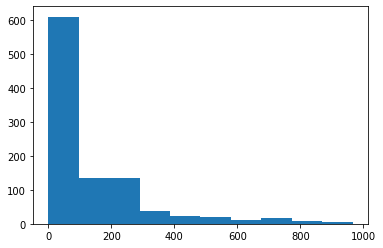

In [421]:
plt.hist(y_train[:1000])

In [422]:
X_train[:100]

[[1, 179.31739130434784, 74.04248897144184],
 [1, 179.31739130434784, 26.72905696505505],
 [1, 179.31739130434784, 27.779840848806366],
 [1, 179.31739130434784, 6.99418426691154],
 [1, 179.31739130434784, 61.11925566343042],
 [1, 179.31739130434784, 7.318484848484848],
 [1, 179.31739130434784, 155.1041022759202],
 [1, 179.31739130434784, 38.886979082211774],
 [1, 179.31739130434784, 136.97599776723416],
 [1, 179.31739130434784, 174.82369942196533],
 [1, 179.31739130434784, 57.638971315529176],
 [1, 179.31739130434784, 7.854843799305774],
 [1, 179.31739130434784, 86.06048387096774],
 [1, 179.31739130434784, 45.04040404040404],
 [1, 179.31739130434784, 174.7219917012448],
 [1, 179.31739130434784, 4.658843007401636],
 [1, 179.31739130434784, 262.9236272107041],
 [1, 179.31739130434784, 34.5105120598478],
 [1, 179.31739130434784, 14.892362864935851],
 [1, 179.31739130434784, 4.836625854428003],
 [1, 179.31739130434784, 113.23824162311712],
 [1, 179.31739130434784, 194.33795959482904],
 [1,

In [423]:
reg = GradientBoostingRegressor(random_state=0)

reg.fit(X_train, y_train)
predict = reg.predict(X_test)

reg.score(X_test, y_test)

0.28723894249570014

In [424]:
MSEtest = sum((y_test - predict)**2)/len(y_test)
MSEtest

32247.895885977367

In [425]:
X_train[:20]

[[1, 179.31739130434784, 74.04248897144184],
 [1, 179.31739130434784, 26.72905696505505],
 [1, 179.31739130434784, 27.779840848806366],
 [1, 179.31739130434784, 6.99418426691154],
 [1, 179.31739130434784, 61.11925566343042],
 [1, 179.31739130434784, 7.318484848484848],
 [1, 179.31739130434784, 155.1041022759202],
 [1, 179.31739130434784, 38.886979082211774],
 [1, 179.31739130434784, 136.97599776723416],
 [1, 179.31739130434784, 174.82369942196533],
 [1, 179.31739130434784, 57.638971315529176],
 [1, 179.31739130434784, 7.854843799305774],
 [1, 179.31739130434784, 86.06048387096774],
 [1, 179.31739130434784, 45.04040404040404],
 [1, 179.31739130434784, 174.7219917012448],
 [1, 179.31739130434784, 4.658843007401636],
 [1, 179.31739130434784, 262.9236272107041],
 [1, 179.31739130434784, 34.5105120598478],
 [1, 179.31739130434784, 14.892362864935851],
 [1, 179.31739130434784, 4.836625854428003]]

In [426]:
y_train[:20]

[6, 0, 7, 0, 0, 0, 0, 0, 333, 75, 338, 0, 2, 286, 633, 0, 696, 0, 37, 0]

In [427]:
aus_item[:10]

[{'user_id': '76561197970982479',
  'items_count': 277,
  'steam_id': '76561197970982479',
  'user_url': 'http://steamcommunity.com/profiles/76561197970982479',
  'items': [{'item_id': '10',
    'item_name': 'Counter-Strike',
    'playtime_forever': 6,
    'playtime_2weeks': 0},
   {'item_id': '20',
    'item_name': 'Team Fortress Classic',
    'playtime_forever': 0,
    'playtime_2weeks': 0},
   {'item_id': '30',
    'item_name': 'Day of Defeat',
    'playtime_forever': 7,
    'playtime_2weeks': 0},
   {'item_id': '40',
    'item_name': 'Deathmatch Classic',
    'playtime_forever': 0,
    'playtime_2weeks': 0},
   {'item_id': '50',
    'item_name': 'Half-Life: Opposing Force',
    'playtime_forever': 0,
    'playtime_2weeks': 0},
   {'item_id': '60',
    'item_name': 'Ricochet',
    'playtime_forever': 0,
    'playtime_2weeks': 0},
   {'item_id': '70',
    'item_name': 'Half-Life',
    'playtime_forever': 0,
    'playtime_2weeks': 0},
   {'item_id': '130',
    'item_name': 'Half-Life:

In [428]:
list(gameid_averagePlayTime.values())[:100]

[74.04248897144184,
 26.72905696505505,
 27.779840848806366,
 6.99418426691154,
 61.11925566343042,
 7.318484848484848,
 155.1041022759202,
 38.886979082211774,
 136.97599776723416,
 174.82369942196533,
 57.638971315529176,
 7.854843799305774,
 86.06048387096774,
 45.04040404040404,
 174.7219917012448,
 4.658843007401636,
 262.9236272107041,
 34.5105120598478,
 14.892362864935851,
 4.836625854428003,
 113.23824162311712,
 194.33795959482904,
 125.29737678855327,
 31.15158371040724,
 76.32785693515557,
 74.38079347423063,
 114.39532680770445,
 178.52291365171249,
 19.163674762407602,
 115.2258064516129,
 66.75990675990676,
 55.01439884809215,
 79.04559457794208,
 13.517998779743746,
 81.34541249036238,
 212.23287086446103,
 169.75222182723073,
 134.75647825428095,
 83.35915492957747,
 103.0311327831958,
 6.827852444952817,
 27.85489721886336,
 13.411238825031928,
 69.5625,
 143.80548128342247,
 57.06578947368421,
 392.11340206185565,
 212.14260814450958,
 57.23481414324569,
 61.74110671

In [429]:
np.average(predict)

128.60551409582678

In [430]:
np.average(list(gameid_averagePlayTime.values()))

86.61874177694553

In [431]:
np.average(y_test[:3000])

123.96133333333333

In [432]:
np.average(y_train[:30000000])

124.2725679325581

In [433]:
y_pred = reg.predict(X_train)
MSEtrain = sum((y_train - y_pred)**2)/len(y_train)
MSEtrain

33690.881968366055

In [434]:
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)
theta = model.coef_

In [435]:
y_testpred = model.predict(X_test)
MSEtest = sum((y_test - y_testpred)**2)/len(y_test)
MSEtest

33144.94323624719

In [436]:
# Regularized regression
clf = linear_model.Ridge(1.0, fit_intercept=False) # MSE + 1.0 l2
clf.fit(X_train, y_train)
theta = clf.coef_
predictions = clf.predict(X_train)

In [442]:
predict[:10]

array([408.95394028, 334.47276135, 489.09162732, 428.41015324,
        19.67488075, 345.62303747, 366.66180671, 369.90038888,
       354.71820666, 253.8643856 ])

In [438]:
y_test[:10]

[549, 0, 565, 790, 0, 166, 552, 686, 853, 79]

In [439]:
X_train[:10]

[[1, 179.31739130434784, 74.04248897144184],
 [1, 179.31739130434784, 26.72905696505505],
 [1, 179.31739130434784, 27.779840848806366],
 [1, 179.31739130434784, 6.99418426691154],
 [1, 179.31739130434784, 61.11925566343042],
 [1, 179.31739130434784, 7.318484848484848],
 [1, 179.31739130434784, 155.1041022759202],
 [1, 179.31739130434784, 38.886979082211774],
 [1, 179.31739130434784, 136.97599776723416],
 [1, 179.31739130434784, 174.82369942196533]]

In [440]:
y_train[:10]

[6, 0, 7, 0, 0, 0, 0, 0, 333, 75]

In [441]:
len(X_train)

3982332

In [ ]:
theta

In [ ]:
result=pd.DataFrame(y_pred, y_train)
result

In [ ]:
sum(y_pred < 0)